In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from star_flow import FlowMatchingModel 

In [7]:
TNG = '/n/netscratch/iaifi_lab/Lab/msliu/flow_double/lightning_logs/TNG/checkpoints/best-model-epoch=76-val_loss=0.002039.ckpt'
Astrid = '/n/netscratch/iaifi_lab/Lab/msliu/flow_double/lightning_logs/Astrid/checkpoints/best-model-epoch=173-val_loss=0.001110.ckpt'
EAGLE = '/n/netscratch/iaifi_lab/Lab/msliu/flow_double/lightning_logs/EAGLE/checkpoints/best-model-epoch=52-val_loss=0.002330.ckpt'
SIMBA = '/n/netscratch/iaifi_lab/Lab/msliu/flow_double/lightning_logs/SIMBA/checkpoints/best-model-epoch=82-val_loss=0.002276.ckpt'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_TNG = FlowMatchingModel.load_from_checkpoint(TNG,map_location=device)
model_TNG.eval()
model_TNG.to(device)
print(f"Loaded model from {TNG}")
model_Astrid = FlowMatchingModel.load_from_checkpoint(Astrid,map_location=device)
model_Astrid.eval()
model_Astrid.to(device)
print(f"Loaded model from {Astrid}")
model_SIMBA = FlowMatchingModel.load_from_checkpoint(SIMBA,map_location=device)
model_SIMBA.eval()
model_SIMBA.to(device)
print(f"Loaded model from {SIMBA}")
model_EAGLE = FlowMatchingModel.load_from_checkpoint(EAGLE,map_location=device)
model_EAGLE.eval()
model_EAGLE.to(device)
print(f"Loaded model from {EAGLE}")

Loaded model from /n/netscratch/iaifi_lab/Lab/msliu/flow_double/lightning_logs/TNG/checkpoints/best-model-epoch=76-val_loss=0.002039.ckpt
Loaded model from /n/netscratch/iaifi_lab/Lab/msliu/flow_double/lightning_logs/Astrid/checkpoints/best-model-epoch=173-val_loss=0.001110.ckpt
Loaded model from /n/netscratch/iaifi_lab/Lab/msliu/flow_double/lightning_logs/SIMBA/checkpoints/best-model-epoch=82-val_loss=0.002276.ckpt
Loaded model from /n/netscratch/iaifi_lab/Lab/msliu/flow_double/lightning_logs/EAGLE/checkpoints/best-model-epoch=52-val_loss=0.002330.ckpt


In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from torch.utils.data import DataLoader

from module import FlowMatchingModel, AstroFlowMatchingDataModule
from utils import AstroMapDataset

In [21]:
def extract_latent_features(model, total_mass_maps, max_samples=1000):
    """Extract features from the bottleneck layer of the U-Net"""
    model.eval()
    device = next(model.parameters()).device
    
    # Hook to capture bottleneck features
    features = []
    
    def hook_fn(module, input, output):
        # Flatten spatial dimensions and store
        batch_features = output.detach().cpu().numpy()
        batch_features = batch_features.reshape(batch_features.shape[0], -1)
        features.append(batch_features)
    
    # Register hook on bottleneck layer
    hook = model.scalar_field.bottleneck.register_forward_hook(hook_fn)
    
    # Limit samples
    n_samples = min(len(total_mass_maps), max_samples)
    total_mass_subset = total_mass_maps[:n_samples]
    
    # Create simple dataloader
    dataset = torch.utils.data.TensorDataset(torch.FloatTensor(total_mass_subset))
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
    
    with torch.no_grad():
        for batch_idx, (total_mass,) in enumerate(dataloader):
            total_mass = total_mass.to(device)
            batch_size = total_mass.size(0)
            
            # Sample random time
            t = torch.rand(batch_size, device=device)
            
            # Create input (just expand total mass to 2 channels)
            total_mass = total_mass.unsqueeze(1)
            x_t = total_mass.expand(-1, 2, -1, -1)
            
            # Forward pass to trigger hook
            _ = model(x_t, t, total_mass)
    
    # Remove hook
    hook.remove()
    
    # Concatenate all features
    all_features = np.concatenate(features, axis=0)
    return all_features

def plot_umap_latent(model_path, total_mass_maps, n_samples=500):
    """Load model and create UMAP visualization of latent features"""
    
    # Load trained model
    model = FlowMatchingModel.load_from_checkpoint(model_path)
    model.eval()
    
    print("Extracting latent features...")
    features = extract_latent_features(model, total_mass_maps, max_samples=n_samples)
    print(f"Extracted features shape: {features.shape}")
    
    # Apply UMAP
    print("Applying UMAP...")
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    embedding = reducer.fit_transform(features)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.6, s=20)
    plt.title('UMAP of Latent Representations (Bottleneck Layer)')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return embedding, features

Extracting latent features...
Extracted features shape: (1000, 131072)
Applying UMAP...


/n/home02/msliu/.conda/envs/env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


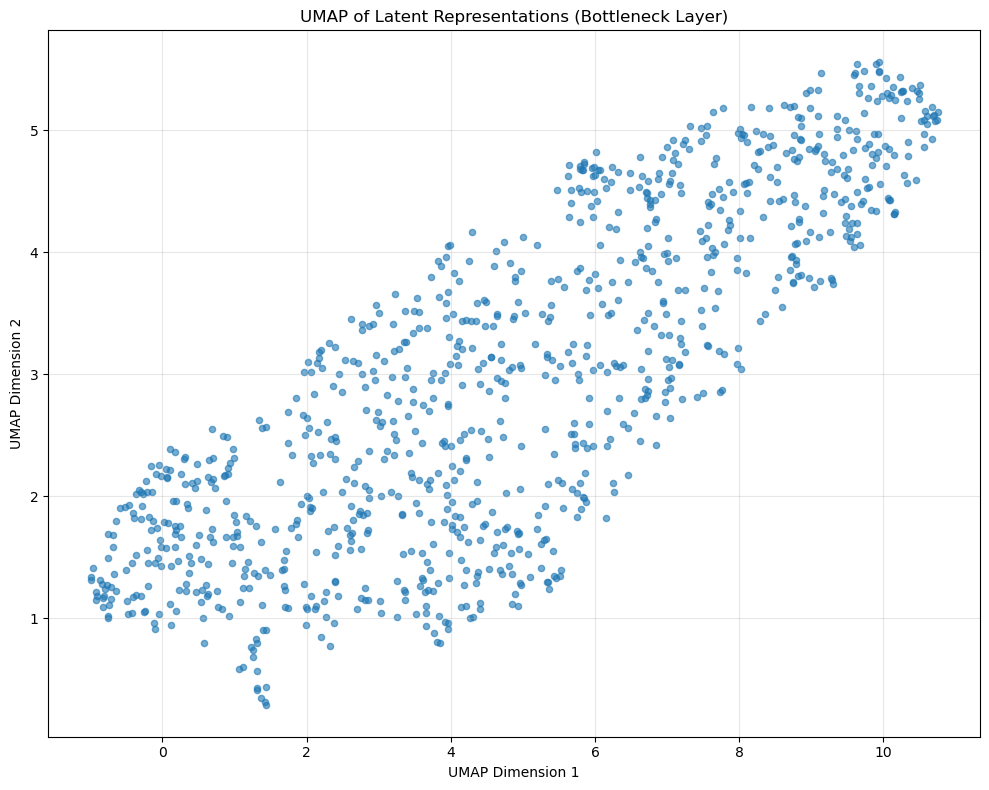

In [23]:
# Load your data (replace with your actual data loading)
total_mass_maps = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy')

# Apply log transform as in your training
total_mass_maps = np.log1p(total_mass_maps)

# Create data module (only need total mass maps)
data_module = AstroFlowMatchingDataModule(
    total_mass_maps=total_mass_maps,
    star_maps=np.zeros_like(total_mass_maps),  # dummy data
    gas_maps=np.zeros_like(total_mass_maps),   # dummy data
    batch_size=16
)

# Path to your trained model checkpoint
model_path = TNG

# Create UMAP visualization
embedding, features = plot_umap_latent(model_path, total_mass_maps, n_samples=1000)

In [29]:
def extract_latent_features(model, total_mass_maps, max_samples=1000):
    """Extract features from the bottleneck layer of the U-Net"""
    model.eval()
    device = next(model.parameters()).device
    
    # Hook to capture bottleneck features
    features = []
    
    def hook_fn(module, input, output):
        # Flatten spatial dimensions and store
        batch_features = output.detach().cpu().numpy()
        batch_features = batch_features.reshape(batch_features.shape[0], -1)
        features.append(batch_features)
    
    # Register hook on bottleneck layer
    hook = model.scalar_field.bottleneck.register_forward_hook(hook_fn)
    
    # Limit samples
    n_samples = min(len(total_mass_maps), max_samples)
    total_mass_subset = total_mass_maps[:n_samples]
    
    # Create simple dataloader
    dataset = torch.utils.data.TensorDataset(torch.FloatTensor(total_mass_subset))
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
    
    with torch.no_grad():
        for batch_idx, (total_mass,) in enumerate(dataloader):
            total_mass = total_mass.to(device)
            batch_size = total_mass.size(0)
            
            # Sample random time
            t = torch.rand(batch_size, device=device)
            
            # Create input (add channel dim, then expand to 2 channels)
            total_mass = total_mass.unsqueeze(1)  # [B, H, W] -> [B, 1, H, W]
            x_t = total_mass.expand(-1, 2, -1, -1)  # [B, 1, H, W] -> [B, 2, H, W]
            
            # Forward pass to trigger hook
            _ = model(x_t, t, total_mass)
    
    # Remove hook
    hook.remove()
    
    # Concatenate all features
    all_features = np.concatenate(features, axis=0)
    return all_features

def plot_multi_model_umap(models_dict, data_dict, n_samples=500):
    """Create UMAP visualization comparing latent features across multiple models"""
    
    all_features = []
    all_labels = []
    
    # Extract features from each model
    for model_name, model in models_dict.items():
        print(f"Extracting features from {model_name}...")
        total_mass_maps = data_dict[model_name]
        features = extract_latent_features(model, total_mass_maps, max_samples=n_samples)
        
        all_features.append(features)
        all_labels.extend([model_name] * len(features))
    
    # Concatenate all features
    combined_features = np.concatenate(all_features, axis=0)
    print(f"Combined features shape: {combined_features.shape}")
    
    # Apply UMAP
    print("Applying UMAP...")
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    embedding = reducer.fit_transform(combined_features)
    
    # Plot with colors for each model
    plt.figure(figsize=(8, 6))
    
    colors = ['#D81B60','#FFC107','#004D40','#5B2E6E']  
    model_names = list(models_dict.keys())
    
    for i, model_name in enumerate(model_names):
        mask = np.array(all_labels) == model_name
        plt.scatter(embedding[mask, 0], embedding[mask, 1], 
                   c=colors[i], label=model_name, alpha=0.6, s=20)
    
    plt.title('UMAP of Latent Representations Across Models')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('sim_latent.png')
    plt.show()
    
    return embedding, combined_features, all_labels

Extracting features from TNG...
Extracting features from Astrid...
Extracting features from EAGLE...
Extracting features from SIMBA...
Combined features shape: (4000, 131072)
Applying UMAP...


/n/home02/msliu/.conda/envs/env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


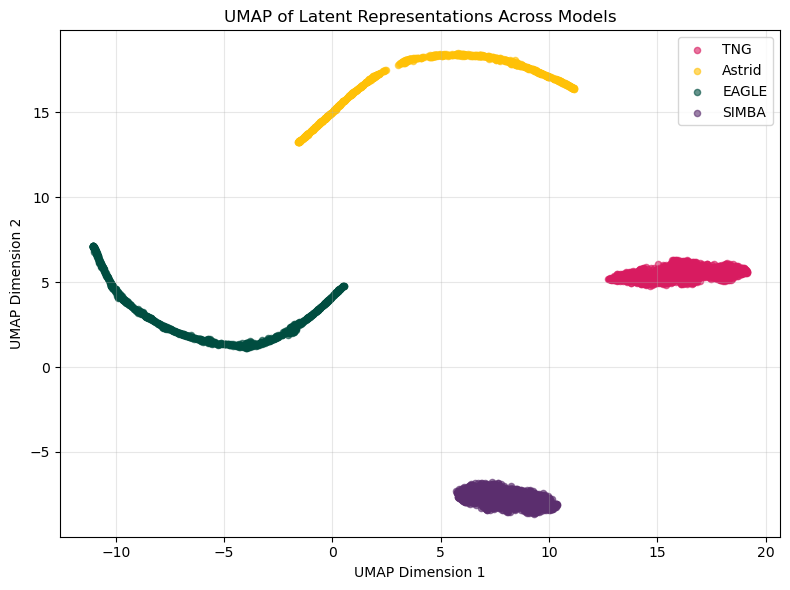

In [30]:

# Load your data for each model
total_mass_TNG = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy')
total_mass_Astrid = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/Astrid/Maps_Mtot_Astrid_LH_z=0.00.npy')
total_mass_EAGLE = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/EAGLE/Maps_Mtot_EAGLE_LH_z=0.00.npy')
total_mass_SIMBA = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/SIMBA/Maps_Mtot_SIMBA_LH_z=0.00.npy')

# Apply log transform
total_mass_TNG = np.log1p(total_mass_TNG)
total_mass_Astrid = np.log1p(total_mass_Astrid)
total_mass_EAGLE = np.log1p(total_mass_EAGLE)
total_mass_SIMBA = np.log1p(total_mass_SIMBA)

# Model paths
TNG = '/n/netscratch/iaifi_lab/Lab/msliu/flow_double/lightning_logs/TNG/checkpoints/best-model-epoch=76-val_loss=0.002039.ckpt'
Astrid = '/n/netscratch/iaifi_lab/Lab/msliu/flow_double/lightning_logs/Astrid/checkpoints/best-model-epoch=173-val_loss=0.001110.ckpt'
EAGLE = '/n/netscratch/iaifi_lab/Lab/msliu/flow_double/lightning_logs/EAGLE/checkpoints/best-model-epoch=52-val_loss=0.002330.ckpt'
SIMBA = '/n/netscratch/iaifi_lab/Lab/msliu/flow_double/lightning_logs/SIMBA/checkpoints/best-model-epoch=82-val_loss=0.002276.ckpt'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load models
models_dict = {
    'TNG': FlowMatchingModel.load_from_checkpoint(TNG, map_location=device),
    'Astrid': FlowMatchingModel.load_from_checkpoint(Astrid, map_location=device),
    'EAGLE': FlowMatchingModel.load_from_checkpoint(EAGLE, map_location=device),
    'SIMBA': FlowMatchingModel.load_from_checkpoint(SIMBA, map_location=device)
}

# Move models to device
for model in models_dict.values():
    model.eval()
    model.to(device)

# Data dictionary
data_dict = {
    'TNG': total_mass_TNG,
    'Astrid': total_mass_Astrid,
    'EAGLE': total_mass_EAGLE,
    'SIMBA': total_mass_SIMBA
}

# Create multi-model UMAP visualization
embedding, features, labels = plot_multi_model_umap(models_dict, data_dict, n_samples=1000)